## Rotary Wings Dataset Analysis
---
Data cleaning and transformation

In [1]:
#load packages
import pandas as pd
import numpy as np
import scipy.stats as st
import xlsxwriter
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
#load data and convert dates to datetime
rw = pd.read_csv("..//Datasets/RW/RW_tail_numbers(cleaned).csv", encoding='latin-1', parse_dates=['dates'])

In [3]:
#inspect data
rw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140845 entries, 0 to 140844
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tail_number  140845 non-null  object        
 1   dates        140845 non-null  datetime64[ns]
 2   aircraft     133203 non-null  object        
 3   origin       140834 non-null  object        
 4   destination  140841 non-null  object        
 5   departure    140845 non-null  object        
 6   arrival      140676 non-null  object        
 7   duration     140641 non-null  object        
 8   NAME         140845 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 9.7+ MB


In [4]:
#glimpse to data 
rw.head()

,tail_number,dates,aircraft,origin,destination,departure,arrival,duration,NAME
0,N101AE,2021-02-07,B06,"Terre Haute, IN","Bloomington, IN",07:12AM EST,09:14AM EST,2:01,AIR EVAC EMS INC ...
1,N101AE,2021-02-05,B06,Cooper,"Indianapolis, IN",07:35PM EST,08:28PM EST,0:52,AIR EVAC EMS INC ...
2,N101AE,2021-02-05,B06,"Indianapolis, IN",Indianapolis Intl,01:02PM EST,01:08PM EST,0:05,AIR EVAC EMS INC ...
3,N101AE,2021-02-02,B06,"Indianapolis, IN",Marcidale,03:54PM EST,04:56PM EST,1:01,AIR EVAC EMS INC ...
4,N101AE,2021-01-23,B06,Frasca Fld,"ChampaignUrbana, IL",09:31PM CST,09:38PM CST,0:06,AIR EVAC EMS INC ...


In [5]:
#chech for null values
rw.isna().sum()

tail_number       0
dates             0
aircraft       7642
origin           11
destination       4
departure         0
arrival         169
duration        204
NAME              0
dtype: int64

In [6]:
#the null duration indicates that the flight was canceled or diverted. So, let's remove it 
rw = rw.dropna(subset=['duration'])

In [7]:
# convert duration to minutes and add a new column 
rw['duration_minutes'] = pd.to_datetime(rw.duration, format="%H:%M").dt.hour * 60 + pd.to_datetime(rw.duration, format="%H:%M").dt.minute

# convert duration to the H:M format
rw.duration = pd.to_datetime(rw.duration, format="%H:%M").dt.time

#rearrange data for the convenience
rw = rw.iloc[:,:8].join([rw.iloc[:,-1], rw.loc[:,'NAME']])

In [8]:
!!!# let's consider flights which more or equal 5 minutes. We don't think that flight that less than 5 minutes has any sense.
rw = rw.query("duration_minutes >= 5")
rw.head()

,tail_number,dates,aircraft,origin,destination,departure,arrival,duration,duration_minutes,NAME
0,N101AE,2021-02-07,B06,"Terre Haute, IN","Bloomington, IN",07:12AM EST,09:14AM EST,02:01:00,121,AIR EVAC EMS INC ...
1,N101AE,2021-02-05,B06,Cooper,"Indianapolis, IN",07:35PM EST,08:28PM EST,00:52:00,52,AIR EVAC EMS INC ...
2,N101AE,2021-02-05,B06,"Indianapolis, IN",Indianapolis Intl,01:02PM EST,01:08PM EST,00:05:00,5,AIR EVAC EMS INC ...
3,N101AE,2021-02-02,B06,"Indianapolis, IN",Marcidale,03:54PM EST,04:56PM EST,01:01:00,61,AIR EVAC EMS INC ...
4,N101AE,2021-01-23,B06,Frasca Fld,"ChampaignUrbana, IL",09:31PM CST,09:38PM CST,00:06:00,6,AIR EVAC EMS INC ...


### Summary statistics
---

In [9]:
# total number of flights by each service and its tail number 
total_flights = pd.DataFrame(rw.groupby("NAME").tail_number.value_counts()).rename({'tail_number':'Number of Flights'}, axis=1)

# Average Flights per Day
avg_total_flights = pd.Series(rw.groupby("NAME").tail_number.value_counts().sort_index() / rw.groupby(['NAME','tail_number']).dates.nunique(), name='Average Flights per Day')

In [10]:
stats = rw.groupby(["NAME", 'tail_number']).duration_minutes.agg(['sum','mean', 'median', 'max', 'min'])\
          .rename({'sum':'Total Duration(min)', 'mean':'Average Duration(min)', 'median':'Median Duration(min)', 'max':'MAX Duration(min)', 'min':'MIN Duration(min)'}, axis=1)

In [11]:
#total summary statistics 
total_stats = total_flights.join([avg_total_flights, stats])
total_stats.head()

Number of Flights  \
NAME                                               tail_number                      
AIR EVAC EMS INC                                   N652AE                     201   
                                                   N336AE                     195   
                                                   N96AE                      195   
                                                   N103AE                     184   
                                                   N395AE                     181   

                                                                Average Flights per Day  \
NAME                                               tail_number                            
AIR EVAC EMS INC                                   N652AE                      3.092308   
                                                   N336AE                      2.635135   
                                                   N96AE                       3.000000   
                                                   N103AE                      2.666667   
                                                   N395AE                      2.623188   

                                                                Total Duration(min)  \
NAME                                               tail_number                        
AIR EVAC EMS INC                                   N652AE                      8684   
                                                   N336AE                     13812   
                                                   N96AE                       7791   
                                                   N103AE                     11640   
                                                   N395AE                     12087   

                                                                Average Duration(min)  \
NAME                                               tail_number                          
AIR EVAC EMS INC                                   N652AE                   43.203980   
                                                   N336AE                   70.830769   
                                                   N96AE                    39.953846   
                                                   N103AE                   63.260870   
                                                   N395AE                   66.779006   

                                                                Median Duration(min)  \
NAME                                               tail_number                         
AIR EVAC EMS INC                                   N652AE                       17.0   
                                                   N336AE                       72.0   
                                                   N96AE                        26.0   
                                                   N103AE                       58.5   
                                                   N395AE                       52.0   

                                                                MAX Duration(min)  \
NAME                                               tail_number                      
AIR EVAC EMS INC                                   N652AE                     296   
                                                   N336AE                     313   
                                                   N96AE                      216   
                                                   N103AE                     276   
                                                   N395AE                     349   

                                                                MIN Duration(min)  
NAME                                               tail_number                     
AIR EVAC EMS INC                                   N652AE                       5  
                                                   N336AE                       5  
                                               

In [12]:
# Origins (where does the flight start each time)
Origins = pd.DataFrame(rw.groupby(['NAME', 'tail_number']).origin.value_counts()).rename({'origin':'Number of Flights'}, axis=1)
Origins.head()

Number of Flights
NAME                                               tail_number origin                             
AIR EVAC EMS INC                                   N101AE      Indianapolis, IN                 13
                                                               Terre Haute, IN                   7
                                                               Sullivan, IN                      6
                                                               Cooper                            2
                                                               Greencastle, IN                   2

In [13]:
# # Create a Pandas Excel writer using XlsxWriter as the engine.
# writer = pd.ExcelWriter('..//Datasets/RW/RW_stats.xlsx', engine='xlsxwriter')

# # Write each dataframe to a different worksheet.
# total_stats.to_excel(writer, sheet_name='stats')
# Origins.to_excel(writer, sheet_name='origin')

# # Close the Pandas Excel writer and output the Excel file.
# writer.save()

## Time Series Analysis
---
Data cleaning and transformation

In [14]:
# split time zone and assign to new variable for arrival
rw['arr_time_zone'] = rw.arrival.str.split(" ", n = 1, expand = True)[1]

# remove time zome from arrival
rw.arrival = rw.arrival.str.split(" ", n = 1, expand = True)[0]

# rearrange data for the convenience 
rw = rw.iloc[:,:7].join([rw.iloc[:,-1], rw.iloc[:,7:10]])

In [15]:
# split time zone and assign to new variable for departure
rw['dep_time_zone'] = rw.departure.str.split(" ", n = 1, expand = True)[1]

# remove time zome from departure
rw.departure = rw.departure.str.split(" ", n = 1, expand = True)[0]

# rearrange data for the convenience 
rw = rw.iloc[:,:6].join([rw.iloc[:,-1], rw.iloc[:,6:11]])

In [16]:
# convert departure time to the 24-format 
rw.departure = pd.to_datetime(rw.departure).dt.strftime('%H:%M')

# convert arrival time to the 24-format 
rw.arrival = pd.to_datetime(rw.arrival, errors='coerce').dt.strftime('%H:%M')

In [17]:
# drop all unconverted records
rw = rw.dropna(subset=['arrival'])

In [18]:
rw.head()

,tail_number,dates,aircraft,origin,destination,departure,dep_time_zone,arrival,arr_time_zone,duration,duration_minutes,NAME
0,N101AE,2021-02-07,B06,"Terre Haute, IN","Bloomington, IN",07:12,EST,09:14,EST,02:01:00,121,AIR EVAC EMS INC ...
1,N101AE,2021-02-05,B06,Cooper,"Indianapolis, IN",19:35,EST,20:28,EST,00:52:00,52,AIR EVAC EMS INC ...
2,N101AE,2021-02-05,B06,"Indianapolis, IN",Indianapolis Intl,13:02,EST,13:08,EST,00:05:00,5,AIR EVAC EMS INC ...
3,N101AE,2021-02-02,B06,"Indianapolis, IN",Marcidale,15:54,EST,16:56,EST,01:01:00,61,AIR EVAC EMS INC ...
4,N101AE,2021-01-23,B06,Frasca Fld,"ChampaignUrbana, IL",21:31,CST,21:38,CST,00:06:00,6,AIR EVAC EMS INC ...


In [19]:
#rw.to_csv(r'/Users/kamil/OneDrive - George Mason University/GMU/Spring 2021/DAEN_690/Datasets/RW_tail_numbers(converted to min and 24-hour format).csv', index=False)

In [20]:
# Let's figure out the date range of our dataset with which we will deal
print("From", rw.dates.dt.date.min(), "to", rw.dates.dt.date.max())

From 2020-10-30 to 2021-02-12


### Tables and graphs

In [21]:
# total number of flight by day
rw_daily_flights = pd.DataFrame(rw.dates.value_counts()).sort_index()
rw_daily_flights.head()

,dates
2020-10-30,483
2020-10-31,1784
2020-11-01,1430
2020-11-02,1588
2020-11-03,1748


As we don't have access to the data for the entire October and February, we have to exclude the first and the last days of these months in our date range. Otherwise, it may give wrong outcomes

In [22]:
# Excluse the first and last days of our data range
rw_daily_flights = rw_daily_flights.loc['2020-10-31':'2021-2-12'].rename({'dates':'Number of flights'}, axis=1)

# Add a moving Average for week window to see trend
rw_daily_flights['Moving average for week window'] = rw_daily_flights['Number of flights'].rolling(window='7D').mean()

# Add a moving Average for 30 days window to see trend
rw_daily_flights['Moving average for 30 days window'] = rw_daily_flights['Number of flights'].rolling(window='30D').mean()

In [23]:
# add Covid19 cases to observe correlation. Source: https://covidtracking.com/data/download
covid19 = pd.read_csv('..//Datasets/covid-19/national-history.csv', parse_dates=['date'], index_col='date')
covid19 = pd.DataFrame(covid19.positiveIncrease.loc['2021-2-12':'2020-10-31']).rename({'positiveIncrease':'Number of cases'}, axis=1)

# Add a moving Average for week window to see trend
covid19['Moving average for week window'] = covid19['Number of cases'].rolling(window='7D').mean()

# Add a moving Average for 30 days window to see trend
covid19['Moving average for 30 days window'] = covid19['Number of cases'].rolling(window='30D').mean()

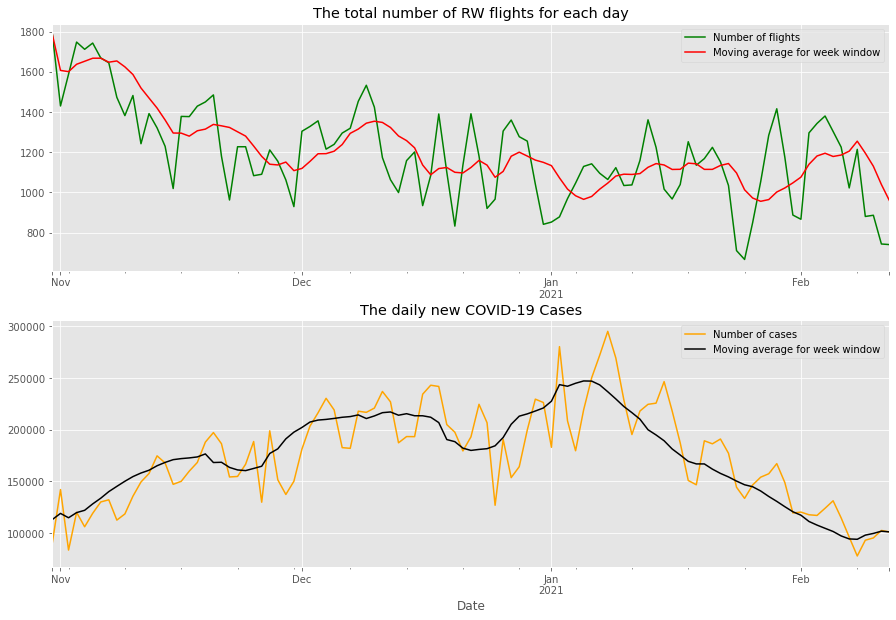

In [24]:
# Let's visualize the number of RW flight for each day with weekly moving average 

fig, ax = plt.subplots(2)
fig.set_size_inches(15, 10)
rw_daily_flights.iloc[:,:-1].plot(ax=ax[0],color=['green', 'red'])
ax[0].set_title("The total number of RW flights for each day")
covid19.iloc[:,:-1].plot(ax=ax[1], color=['orange', 'black'])
ax[1].set_title("The daily new COVID-19 Cases")
plt.xlabel("Date")
plt.savefig('RW_weekly_covid.jpeg')
plt.show()

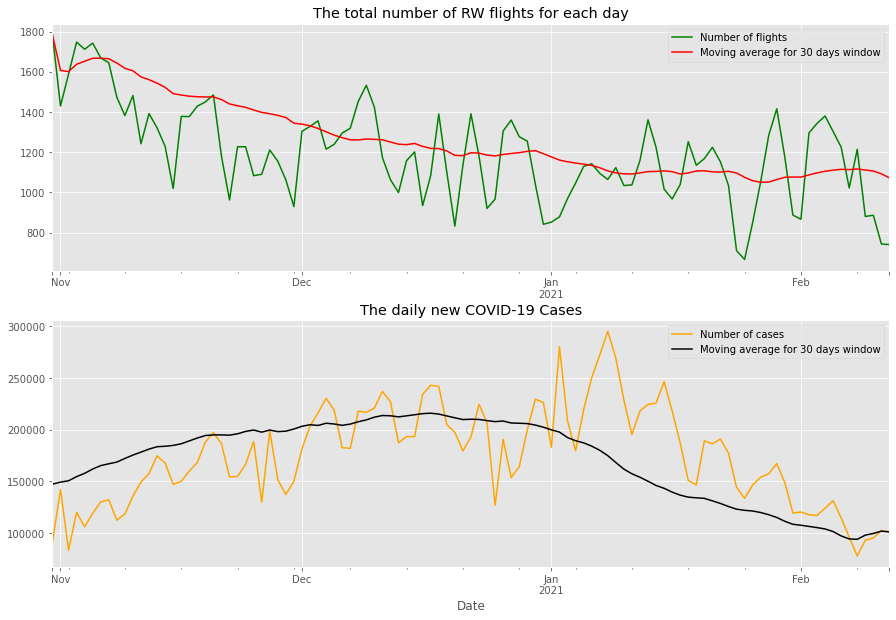

In [25]:
# Let's visualize the number of RW flight for each day with 30-days moving average 

fig, ax = plt.subplots(2)
fig.set_size_inches(15, 10)
rw_daily_flights.iloc[:,[0,2]].plot(ax=ax[0],color=['green', 'red'])
ax[0].set_title("The total number of RW flights for each day")
covid19.iloc[:,[0,2]].plot(ax=ax[1], color=['orange', 'black'])
ax[1].set_title("The daily new COVID-19 Cases")
plt.xlabel("Date")
plt.savefig('RW_monthly_covid.jpeg')
plt.show()

In [26]:
# create new variable of flight duration for each day from 2020-10-31 to 2021-2-12
rw_duration = rw.duration_minutes.sort_index()

In [27]:
# create new variable of flight duration for each day from 2020-10-31 to 2021-2-12 and calculate average duration for each day
rw_avg_duration = pd.DataFrame(rw.groupby('dates').duration_minutes.mean()).rename({'duration_minutes':'Average duration'}, axis=1)\
                    .loc['2020-10-31':'2021-2-12']

# remove index name
rw_avg_duration.index.name = None

In [28]:
# Add a moving Average for week window to see trend
rw_avg_duration['Moving average for week window'] = rw_avg_duration['Average duration'].rolling(window='7D').mean()

# Add a moving Average for 30 days window to see trend
rw_avg_duration['Moving average for 30 days window'] = rw_avg_duration['Average duration'].rolling(window='30D').mean()

rw_avg_duration.head()

,Average duration,Moving average for week window,Moving average for 30 days window
2020-10-31,31.133969,31.133969,31.133969
2020-11-01,30.577622,30.855795,30.855795
2020-11-02,31.064861,30.925484,30.925484
2020-11-03,33.056064,31.458129,31.458129
2020-11-04,33.772196,31.920943,31.920943


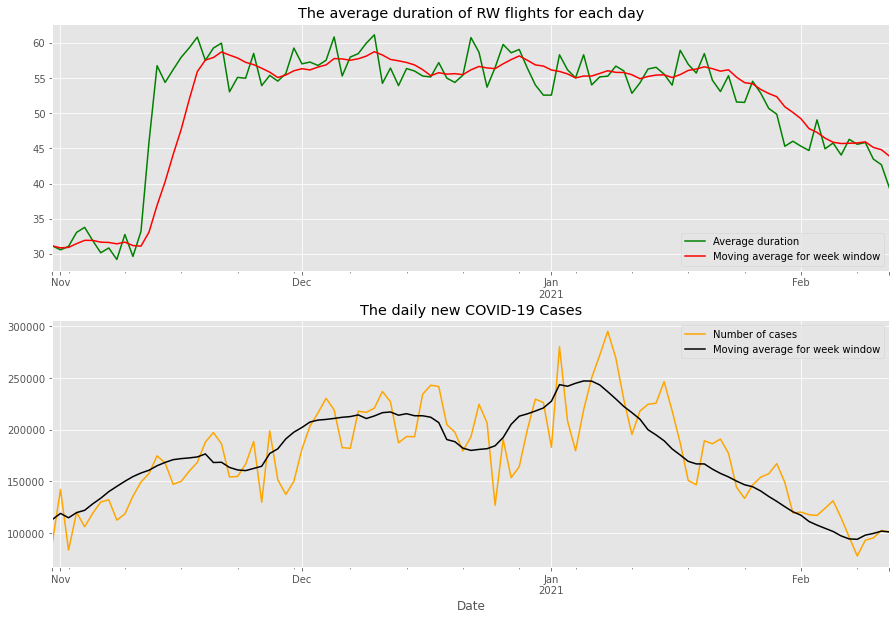

In [29]:
# Let's visualize the average duration of RW flight for each day

fig, ax = plt.subplots(2)
fig.set_size_inches(15, 10)
rw_avg_duration.iloc[:,:-1].plot(ax=ax[0],color=['green', 'red'])
ax[0].set_title("The average duration of RW flights for each day")
covid19.iloc[:,:-1].plot(ax=ax[1], color=['orange', 'black'])
ax[1].set_title("The daily new COVID-19 Cases")
plt.xlabel("Date")
plt.savefig('avg_RW_weekly_covid.jpeg')
plt.show()

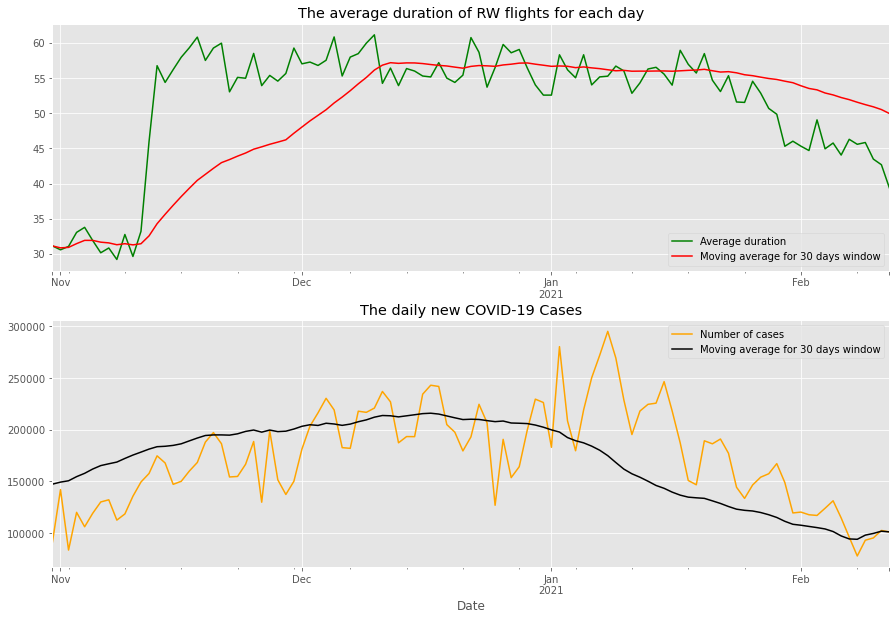

In [30]:
# Let's visualize the average duration of RW flight for each day with monthly moving average

fig, ax = plt.subplots(2)
fig.set_size_inches(15, 10)
rw_avg_duration.iloc[:,[0,2]].plot(ax=ax[0],color=['green', 'red'])
ax[0].set_title("The average duration of RW flights for each day")
covid19.iloc[:,[0,2]].plot(ax=ax[1], color=['orange', 'black'])
ax[1].set_title("The daily new COVID-19 Cases")
plt.xlabel("Date")
plt.savefig('avg_RW_monthly_covid.jpeg')
plt.show()

In [31]:
# hourly shift scheduling
rw_hour_shift  = rw[['dates', 'departure', 'arrival']].set_index('dates')

In [32]:
# conver and extract hour for each date 
rw_hour_shift.departure = pd.to_datetime(rw_hour_shift.departure).dt.hour
rw_hour_shift.arrival = pd.to_datetime(rw_hour_shift.arrival).dt.hour

In [33]:
rw_hour_shift.head()

,departure,arrival
dates,,
2021-02-07,7,9
2021-02-05,19,20
2021-02-05,13,13
2021-02-02,15,16
2021-01-23,21,21


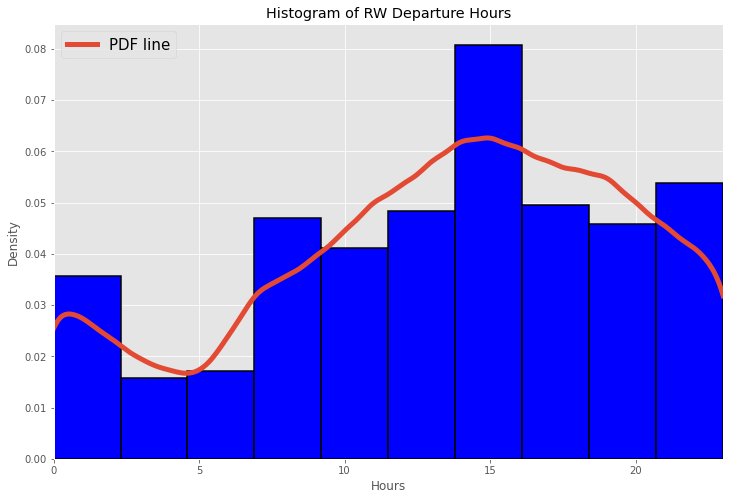

In [34]:
# plot the histogram of departure hours 
plt.figure(figsize=(12,8))
plt.hist(rw_hour_shift.departure, density=True, color='blue', edgecolor='black', linewidth=1.5)
plt.xlim(left = 0, right=23)
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(rw_hour_shift.departure)
plt.plot(kde_xs, kde.pdf(kde_xs), linewidth=5, label="PDF line")
plt.legend(loc="upper left", prop={'size': 15})
plt.xlabel('Hours')
plt.ylabel('Density')
plt.title('Histogram of RW Departure Hours')
plt.savefig('rw_dep_hour_hist.jpeg')

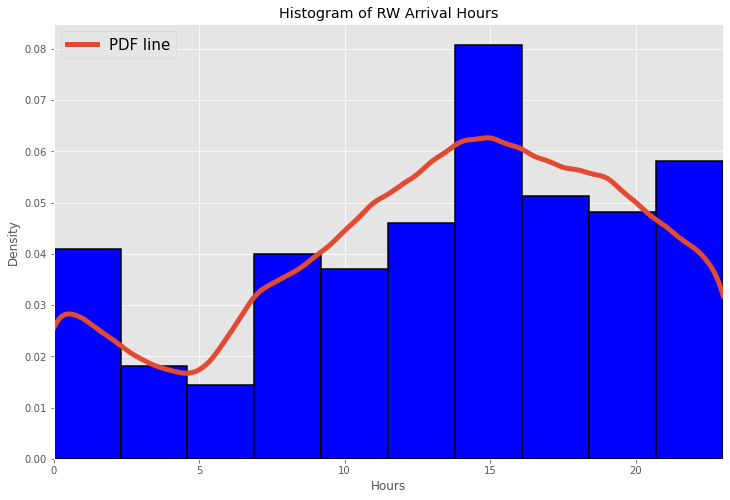

In [35]:
# plot the histogram of arrival hours 
plt.figure(figsize=(12,8))
plt.hist(rw_hour_shift.arrival, density=True, color='blue', edgecolor='black', linewidth=1.5)
plt.xlim(left = 0, right=23)
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(rw_hour_shift.departure)
plt.plot(kde_xs, kde.pdf(kde_xs), linewidth=5, label="PDF line")
plt.legend(loc="upper left", prop={'size': 15})
plt.xlabel('Hours')
plt.ylabel('Density')
plt.title('Histogram of RW Arrival Hours')
plt.savefig('rw_arr_hour_hist.jpeg')